Bob Does Sports Sentiment Analysis


In [2]:
import os
import pandas as pd
import re
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Set up YouTube API
from googleapiclient.discovery import build
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

API_KEY = os.getenv("YOUTUBE_API_KEY")
VIDEO_ID = "LqyprUHo4H0" 

def get_youtube_comments(api_key, video_id, max_results=200):
    """Fetch comments from a YouTube video using the YouTube Data API."""
    youtube = build("youtube", "v3", developerKey=api_key)
    
    comments = []
    next_page_token = None

    while len(comments) < max_results:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            textFormat="plainText",
            maxResults=min(200, max_results - len(comments)),  
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response.get("items", []):
            comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            comments.append(comment)

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break  # No more comments available

    return comments

In [4]:
def clean_comment(comment):
    """Remove special characters, links, and excessive whitespace."""
    comment = re.sub(r"http\S+|www\S+", "", comment)  # Remove URLs
    comment = re.sub(r"[^a-zA-Z0-9\s]", "", comment)  # Remove special characters
    comment = re.sub(r"\s+", " ", comment).strip()  # Remove extra whitespace
    return comment

def analyze_sentiment(comments):
    """Perform sentiment analysis on comments using VADER."""
    sia = SentimentIntensityAnalyzer()
    sentiment_data = []

    for comment in comments:
        cleaned_comment = clean_comment(comment)
        if cleaned_comment:  # Avoid empty comments
            sentiment_score = sia.polarity_scores(cleaned_comment)
            sentiment_data.append({
                "comment": cleaned_comment,
                "positive": sentiment_score["pos"],
                "neutral": sentiment_score["neu"],
                "negative": sentiment_score["neg"],
                "compound": sentiment_score["compound"],
            })

    return pd.DataFrame(sentiment_data)

In [5]:
if __name__ == "__main__":
    print("Fetching comments...")
    comments = get_youtube_comments(API_KEY, VIDEO_ID, max_results=200)

    if comments:
        print(f"Retrieved {len(comments)} comments. Analyzing sentiment...")
        sentiment_df = analyze_sentiment(comments)
        
        # Save to CSV
        csv_filename = "youtube_sentiment_analysis.csv"
        sentiment_df.to_csv(csv_filename, index=False, encoding="utf-8")
        
        print(f"Sentiment analysis saved to {csv_filename}.")
    else:
        print("No comments retrieved.")

Fetching comments...
Retrieved 200 comments. Analyzing sentiment...
Sentiment analysis saved to youtube_sentiment_analysis.csv.


                                             comment  positive  neutral  \
0   Our Breezy X The Players merch collab is out now     0.000    1.000   
1               The TikJet is an ALL time cart combo     0.000    1.000   
2  I came for the golf Stayed for the cart cam of...     0.000    1.000   
3  BDS Im very far from a pro but try swinging 75...     0.153    0.847   
4     Jet looks like a bargain basement Jake Johnson     0.462    0.538   

   negative  compound  
0       0.0    0.0000  
1       0.0    0.0000  
2       0.0    0.0000  
3       0.0    0.5023  
4       0.0    0.5106  
sentiment
Positive    85
Neutral     78
Negative    36
Name: count, dtype: int64


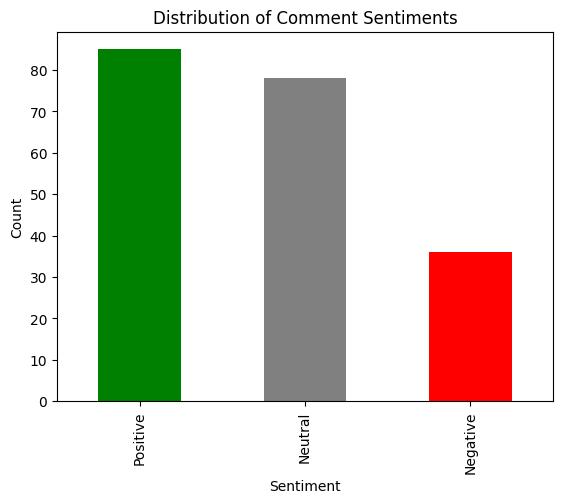

In [6]:
# Display the first few rows
import matplotlib.pyplot as plt
df = pd.read_csv("youtube_sentiment_analysis.csv")
print(df.head())

df["sentiment"] = df["compound"].apply(lambda x: "Positive" if x > 0.05 else "Negative" if x < -0.05 else "Neutral")

# Count the number of comments in each category
print(df["sentiment"].value_counts())

df["sentiment"].value_counts().plot(kind="bar", color=["green", "gray", "red"])
plt.title("Distribution of Comment Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


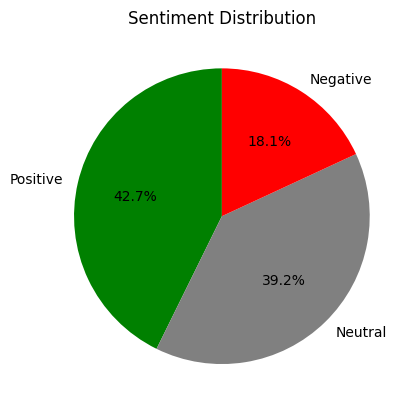

In [7]:
sentiment_counts = df["sentiment"].value_counts()

sentiment_counts.plot(kind="pie", autopct="%1.1f%%", colors=["green", "gray", "red"], startangle=90)
plt.title("Sentiment Distribution")
plt.ylabel("")  # Remove the default y-axis label
plt.show()

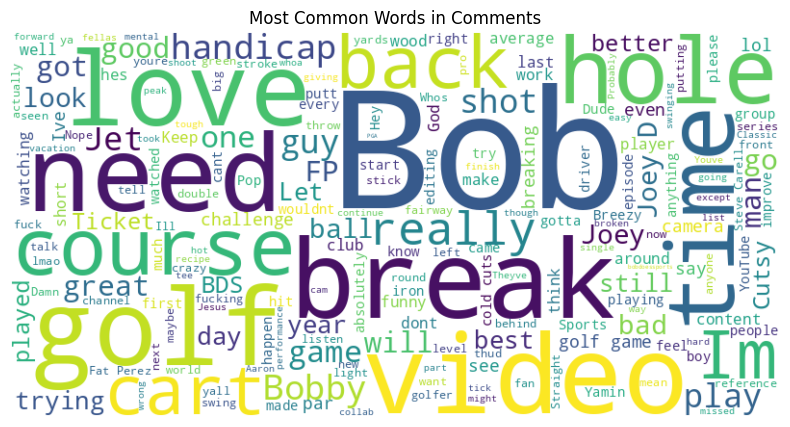

In [8]:
from wordcloud import WordCloud

text = " ".join(comment for comment in df["comment"])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Comments")
plt.show()

In [9]:
# Count the occurrences of the word "love" (case-insensitive) in the comments
love_count = df["comment"].str.count(r"\blove\b", flags=re.IGNORECASE).sum()

print(f"The word 'love' is used {love_count} times in the comments.")

The word 'love' is used 17 times in the comments.


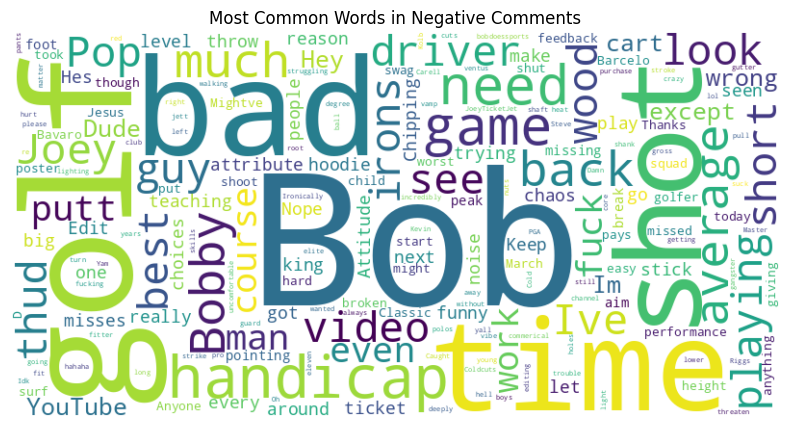

In [10]:
negative_comments = " ".join(df[df["sentiment"] == "Negative"]["comment"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_comments)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Negative Comments")
plt.show()

In [11]:
# Filter comments containing the word "time"
time_negative_comments = df[df["comment"].str.contains(r"\btime\b", case=False, na=False)]

# Sort by the "negative" score in descending order
top_time_negative_comments = time_negative_comments.sort_values(by="negative", ascending=False).head(10)

# Display the top 10 negative comments
print(top_time_negative_comments[["comment", "negative"]])

                                               comment  negative
173                   I felt bad for Bobthe whole time     0.412
77   No matter what Im still deeply hurt to my core...     0.280
180  Tiger Woods would have a difficult time playin...     0.153
155  I like bob but I stopped watching Bob a while ...     0.143
41   How can a guy throw a strike then next time th...     0.130
112  Jet and papi having the time of their lives an...     0.127
149  Its really shown in the past 2 episodes how mu...     0.062
3    BDS Im very far from a pro but try swinging 75...     0.000
1                 The TikJet is an ALL time cart combo     0.000
128  Bobdoessports i request to face Bob in a 1v1 s...     0.000


In [12]:
top_negative_comments = df.sort_values(by="negative", ascending=False).head(20)
#print(top_negative_comments[["comment", "negative"]])